# Evaluate our current models on different datasets for clustering

### Amazon Reviews Dataset

In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from datasets import load_dataset

dataset = load_dataset("amazon_polarity", split="train")
dataset = dataset.shuffle(seed=916).select(range(100000))

In [3]:
dataset

Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 100000
})

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("cayjobla/all-mpnet-base-v2-compressed")

/home/cayjobla/miniconda3/envs/reduced_encoders/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
def tokenize(batch):
    return tokenizer(batch["content"], truncation=True, padding="max_length", return_tensors="pt")

tokenized = dataset.map(tokenize, batched=True, batch_size=1000, remove_columns=dataset.column_names).with_format("torch")

In [6]:
from reduced_encoders import MPNetCompressedModel

model = MPNetCompressedModel.from_pretrained("all-mpnet-base-v2-compressed-umap").to(device)

In [7]:
def encode(batch):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
    return {"reduced": outputs.last_hidden_state.cpu().detach(), 
            "full": outputs.unreduced_pooler_output.cpu().detach()}

embeddings = tokenized.map(encode, batched=True, batch_size=100, remove_columns=tokenized.column_names)

## Cluster

### DenStream

In [8]:
from river.cluster import DenStream
from utils import visualize_clusters as visualize

class DenStreamAnalyze(DenStream):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.clustering_is_up_to_date = False

    def _get_closest_cluster_within_eps(self, point, clusters):
        min_distance = self.epsilon
        key = -1
        for k, cluster in clusters.items():
            center = cluster.calc_center(self.timestamp)
            distance = self._distance(center, point)
            if distance <= min_distance:
                min_distance = distance
                key = k
        return key

    def _recluster(self):
        """Implementation of the DBSCAN algorithm proposed by Ester et al."""
        if self.clustering_is_up_to_date or not self.initialized:
            return      # No need to recompute clusters

        # Initialize
        c = -1          # Cluster counter
        labels = {pmc: None for pmc in self.p_micro_clusters.values()}

        for pmc in self.p_micro_clusters.values():
            if labels[pmc] is not None:         # Micro-cluster already assigned
                continue

            # New cluster
            c += 1
            labels[pmc] = c

            seed_queue = self._query_neighbor(pmc)
            while seed_queue:
                if labels[seed_queue[0]] is not None:
                    seed_queue.popleft()        # Micro-cluster already assigned
                else:
                    labels[seed_queue[0]] = c   # Assign micro-cluster to cluster
                    neighbor_neighbors = self._query_neighbor(seed_queue[0])
                    for neighbor_neighbor in neighbor_neighbors:
                        if labels[neighbor_neighbor] is not None:       # TODO: There was a bug here in the original code
                            seed_queue.append(neighbor_neighbor)

        self.n_clusters, self.clusters = self._generate_clusters_for_labels(labels)
        self.clustering_is_up_to_date = True

    def _format_x(self, x):
        if not isinstance(x, dict):
            try:
                x = {d:val for d, val in enumerate(x)}
            except:
                raise ValueError(f"Input data must be a dictionary or array, got {type(x)}")
        return x

    def learn_one(self, x):
        x = self._format_x(x)
        self.clustering_is_up_to_date = False
        super().learn_one(x)

    def predict_one(self, x):
        x = self._format_x(x)
        self._recluster()
        return self._get_closest_cluster_within_eps(x, self.clusters)

    def predict(self, X):
        return [self.predict_one(x) for x, _ in stream.iter_array(X)]

    @property
    def centers(self):
        return np.array([list(cluster.calc_center(self.timestamp).values()) 
                         for cluster in self.clusters.values()])

    def plot_clusters(self, X, reduction=None, ax=None, **kwargs):
        """Predict the clusters of the data points and plot them."""
        # Predict the cluster of each data point
        labels = self.predict(X)

        # Reduce the data points to 2D
        if reduction is None:
            X_2d = X
            centers_2d = self.centers
        else:
            X_2d = reduction.transform(X)
            centers_2d = reduction.transform(self.centers)
        if X_2d.shape[1] > 2:
            raise ValueError("The reduced data points have more than 2 dimensions, so they cannot be plotted."
                             "Please provide a reduction with 2 dimensions to plot the clusters.")

        # Plot the clusters
        if ax is None:
            fig, ax = plt.subplots()
        points = visualize.plot_clusters(X_2d, labels, n_components=2, ax=ax, **kwargs)

        # Plot the cluster centers
        cmap, norm = visualize.get_cluster_colormap(num_clusters=len(self.centers), 
                                                    outliers=False, 
                                                    cmap=kwargs.get("cmap", "hsv"))
        centers = ax.scatter(*centers_2d.T, s=100, c=np.arange(len(centers_2d)), marker="+", cmap=cmap, norm=norm)

        return points, centers


2024-06-07 12:27:09.199052: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 12:27:10.197543: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
from river import stream

denstream = DenStreamAnalyze(
    decaying_factor=0.25,
    beta=0.75,
    mu=2.,
    epsilon=1.,
    n_samples_init=100,
    stream_speed=100,           # Either decay needs to be small or stream_speed needs to be large (I think)
)

In [10]:
X = embeddings["reduced"].numpy()[:1000]

for x, _ in stream.iter_array(X):
    denstream.learn_one(x)

NameError: name 'outliers' is not defined

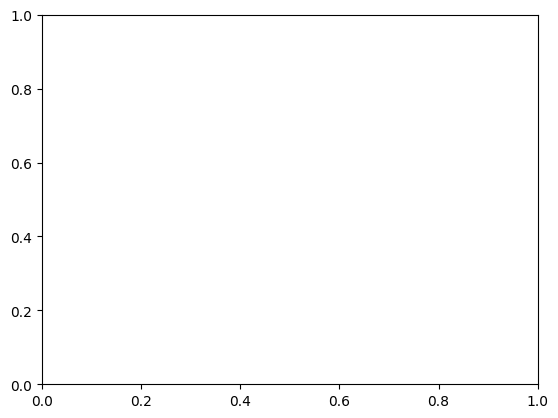

In [11]:
from utils.visualize_clusters import plot_clusters

labels = [denstream.predict_one(x) for x, _ in stream.iter_array(X)]
plot_clusters(X, labels, n_components=2)
plt.show()

***Issues I have with the DenStream implementation as it stands***
- Implementation initialization is not consistent with the paper, uses $\mu$ instead of $\beta \mu$ as a threshold
- Implementation DEFINITELY IS overwriting o-micro-clusters (see the _merge method, specifically where o-micro-clusters become p-micro-clusters and where new o-micro-clusters are created)
    * The below example demonstrates the problem with the current implementation
    * Also breaks convention in the _merge method and sets merged_status to True at the very end for no reason (it wasn't merged into a p-micro-cluster and that variable isn't used again anyway)
    * This issue shows up again in the learn_one method, with both the p-micro-clusters and o-micro-clusters (the .pop() method causes the same issue as the _merge method)
- Clustering is performed each time the predict_one method is called, which is inefficient when doing a lot of predictions without updating the model
- When not initialized, the model should not predict anything, but the implementation returns class index 0 (should be an noise index like -1, or should throw error)
- There is a bug on line 387 in the predict_one method where the clustering adds neighbors of the neighbors that have already been labelled when it should add the ones that have not been labelled. As it stands, neighbors of neighbors are added and then removed by the earlier if statement on line 378.
- The final clustering of the implementation does not allow for noise/outliers since it just naively finds the closest cluster to each point
- The implementation does not do anything that the paper describes about accounting for deletion of micro-clusters, such as the overlapping problem in Figure 3

***NOTE***: Definition 4.1 in the paper is not explicit in whether $c_p$ AND $c_q$ must both be core-micro-clusters, or just $c_q$, and $c_p$ can be just a p-micro-cluster. The implementation assumes the former, which I agree with, since that allows direct density reachability to be commutative.

### DBStream

In [17]:
from river import cluster
from river import stream

dbstream = cluster.DBSTREAM(
    clustering_threshold=1.5,
    fading_factor=0.05,
    cleanup_interval=4,
    intersection_factor=0.5,
    minimum_weight=1
)

In [18]:
X = embeddings["reduced"].numpy()[:1000]
for x, _ in stream.iter_array(X):
    dbstream.learn_one(x)

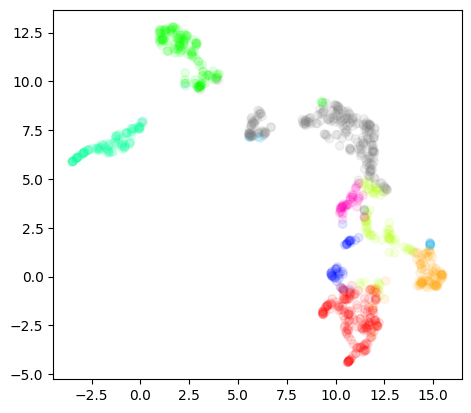

In [19]:
from utils.visualize_clusters import plot_clusters

labels = [dbstream.predict_one(x) for x, _ in stream.iter_array(X)]
plot_clusters(X, labels, n_components=2)
plt.show()

## Visualization

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from umap import UMAP
from river import stream
from utils.visualize_clusters import get_cluster_colormap


def animation(clusterer, X, reduction, plot_micro_clusters=False, interval=20, **kwargs):
    """Create an animation object that visualizes the streamed clustering process.
    
    Parameters:
        clusterer: The clustering model to use in visualizing the data stream
        X (np.ndarray): The set of data points to visualize
        reduction: The reduction model to use for reducing the data points to 2D
        interval (int): The time interval between frames in the animation (ms)
    """
    # Reduce the data points to 2D
    def reduce(X):
        if reduction is None:
            return X
        return reduction.transform(X)

    X_2d = reduce(X)
    if X_2d.shape[1] > 2:
        raise ValueError("The reduced data points have more than 2 dimensions, so they cannot be plotted."
                         "Please provide a reduction with 2 dimensions to plot the clusters.")

    # Initialize variables
    data_stream = stream.iter_array(X)
    labels = -1 * np.ones(len(X))

    # Initialize figure
    fig, ax = plt.subplots()
    n_cmap_clusters = 10   # Initial number of cluster colors to pull from the colormap
    cmap, norm = get_cluster_colormap(num_clusters=n_cmap_clusters, outliers=True, cmap="hsv")

    # Initialize scatter plot (boundaries, size, color, alpha, etc.)
    points = ax.scatter(*X_2d.T, s=10, c=labels, cmap=cmap, norm=norm, alpha=0.05)
    centers = ax.scatter([], [], s=100, c=[], marker="+", cmap=cmap, norm=norm, alpha=1.0)  
    micro_clusters = ax.scatter([], [], s=100, c=[], marker="*", cmap=cmap, norm=norm, alpha=1.0)
        
    def init_func():
        points.set_offsets(X_2d[:0])
        points.set_array(labels[:0])
        return points, centers, micro_clusters

    def update(i, labels, n_cmap_clusters):
        # Add the new point to the clusterer
        clusterer.learn_one(next(data_stream)[0])  

        # Update clusters every stream time step
        if i % clusterer.stream_speed == 0 and i >= clusterer.n_samples_init:   
            labels[:i+1] = clusterer.predict(X[:i+1])
            if n_cmap_clusters < clusterer.n_clusters:  # Update the colormap to account for more clusters
                clusterer._recluster()
                n_cmap_clusters = clusterer.n_clusters
                cmap, norm = get_cluster_colormap(num_clusters=n_cmap_clusters, outliers=True, cmap="hsv")
                points.set_cmap(cmap)
                points.set_norm(norm)
                centers.set_cmap(cmap)
                centers.set_norm(norm)
                micro_clusters.set_cmap(cmap)
                micro_clusters.set_norm(norm)
            centers_2d = reduce(clusterer.centers)   # Update the cluster center points
            centers.set_offsets(centers_2d)
            centers.set_array(np.arange(clusterer.n_clusters))
            if plot_micro_clusters:
                micro_clusters_2d = reduce([list(mc.calc_center(clusterer.timestamp).values()) for mc in clusterer.p_micro_clusters.values()])
                micro_clusters.set_offsets(micro_clusters_2d)
                micro_clusters.set_array(np.arange(len(clusterer.p_micro_clusters)))

        # Update the data points
        points.set_offsets(X_2d[:i+1])
        points.set_array(labels[:i+1])

        return points, centers

    # Return the animation object
    return FuncAnimation(fig, update, init_func=init_func, frames=len(X), interval=interval, blit=True,
                         fargs=(labels, n_cmap_clusters), **kwargs)

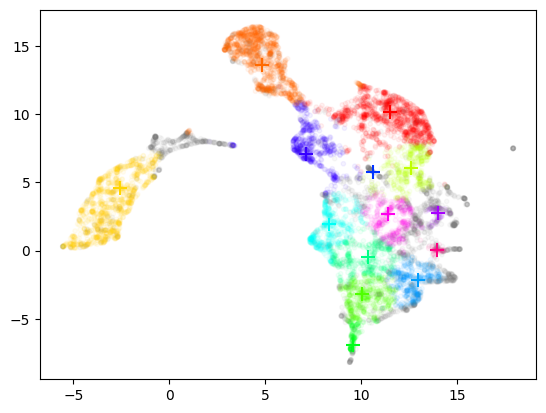

In [15]:
clusterer = DenStreamAnalyze(
    decaying_factor=0.25,
    beta=0.75,
    mu=2.,
    epsilon=1.,
    n_samples_init=250,
    stream_speed=250,
)
X = embeddings["reduced"].numpy()[:10000]
reduction = UMAP(n_components=2).fit(X)

animation(clusterer, X, reduction, interval=2).save("denstream.mp4", writer="ffmpeg")

In [22]:
temp: dict[int, int] = {i:2*i for i in range(10)}   # Dictionary of values
print(temp)
del temp[2]                         # When deleting, the length is decremented
print(temp)
temp[len(temp)] = 100               # Then, when assigning again, the length is equal to an old key, and that value is overwritten
print(temp)                         # See, the value for key 9 is now 100, and the 18 is lost

{0: 0, 1: 2, 2: 4, 3: 6, 4: 8, 5: 10, 6: 12, 7: 14, 8: 16, 9: 18}
{0: 0, 1: 2, 3: 6, 4: 8, 5: 10, 6: 12, 7: 14, 8: 16, 9: 18}
{0: 0, 1: 2, 3: 6, 4: 8, 5: 10, 6: 12, 7: 14, 8: 16, 9: 100}


## Next steps:

1. Generate a synthetic dataset where you can track clusters over time, such as multiple gaussian blobs whose means move around over time
2. Maybe look into contributing to DenStream implementation in River library (?)
3. Make the animation function part of the utils.visualize_clusters file
4. Do this stuff for DBStream
5. Figure out how to do hyperparameter optimization for these streaming clustering models

## Synthetic Data

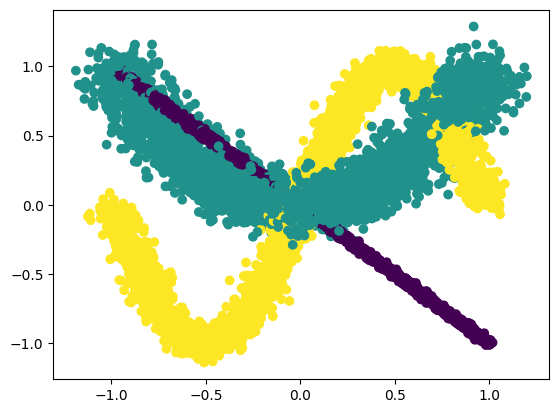

In [3]:
from sklearn.datasets import make_blobs
import numpy as np

num_points=10000
functions = [lambda t: np.array([t,-t]), 
            lambda t: np.array([t,t**2]), 
            lambda t: np.array([t,np.sin(np.pi*t)])]
f_std = [0.01, 0.1, 0.05]
T = np.linspace(-1, 1, num_points)

labels = np.random.choice(len(functions), num_points)
sampled_centers = np.array([[functions[i](t)] for i, t in zip(labels, T)])
data = np.vstack([make_blobs(n_samples=1, centers=c, n_features=2, cluster_std=f_std[l])[0] 
                    for c, l in zip(sampled_centers, labels)])

plt.scatter(*data.T, c=labels, cmap="viridis")
plt.show()


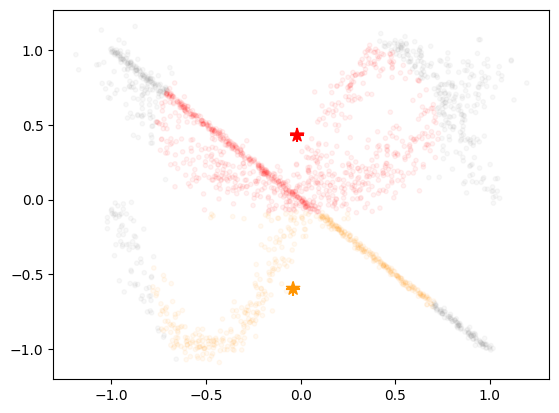

In [6]:
clusterer = DenStreamAnalyze(
    decaying_factor=0.5,
    beta=0.75,
    mu=2.,
    epsilon=.75,
    n_samples_init=250,
    stream_speed=50,
)

animation(clusterer, data[::5], plot_micro_clusters=True, reduction=None, interval=2).save("denstream_synthetic.mp4", writer="ffmpeg")

In [26]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from river import stream
from umap import UMAP

clusterer = DenStreamAnalyze(
    decaying_factor=0.25,
    beta=0.75,
    mu=2.,
    epsilon=1.,
    n_samples_init=100,
    stream_speed=100,
)
X = embeddings["reduced"].numpy()[:1000]

# Train the visualization reduction
umap = UMAP(n_components=2).fit(X)     # Would PCA be better for this?

# TODO: Incorporate these plotting functions into my custom class
# TODO: Add an option to let alpha be a function of point weight
# TODO: Add option to plot cluster centers/radii (does radius make sense in the 2d space after reduction?)
# TODO: Maybe add a way to track what micro-cluster a point is added to when learned (to track noise points better)?
# TODO: Get the animation working (eventually?)

# TODO: Finally, do all this for DBStream and compare the two   
#       I will need metric(s) to compare the clusters

for i, (x, _) in enumerate(stream.iter_array(X)):
    clusterer.learn_one(x)  
    if i % clusterer.stream_speed == 0 and i >= clusterer.n_samples_init:
        clusterer.plot_clusters(X[:i+1], reduction=umap)
        plt.show()

In [10]:
# %matplotlib ipympl

<Axes: >

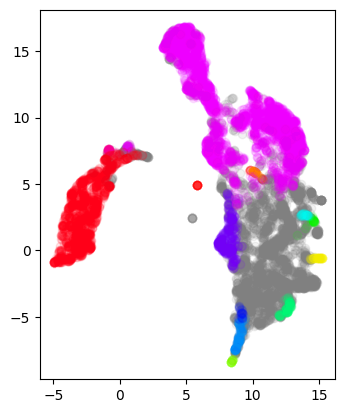

In [28]:
from utils.visualize_clusters import plot_clusters

plot_clusters(embeddings["reduced"], clusters.labels_, n_components=2)

<Axes: >

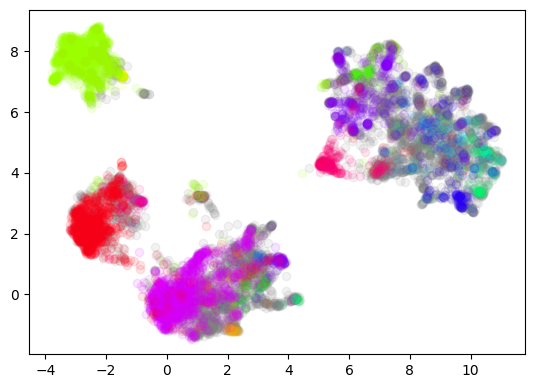

In [12]:
plot_clusters(embeddings["full"], clusters.labels_, n_components=2)

#### Cluster with Cosine Similarity Distance

In [13]:
import torch

cos_sim = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
similarity_matrix = cos_sim(embeddings["reduced"].unsqueeze(0), embeddings["reduced"].unsqueeze(1))

In [14]:
similarity_matrix.shape

torch.Size([10000, 10000])

In [15]:
1-similarity_matrix[:5,:5]

tensor([[ 0.0000e+00,  1.2755e-03,  6.1562e-02,  4.1294e-04,  5.2545e-01],
        [ 1.2755e-03,  5.9605e-08,  6.2085e-02,  1.4993e-03,  5.1614e-01],
        [ 6.1562e-02,  6.2085e-02,  1.1921e-07,  5.5449e-02,  7.4853e-01],
        [ 4.1294e-04,  1.4993e-03,  5.5449e-02, -1.1921e-07,  5.3123e-01],
        [ 5.2545e-01,  5.1614e-01,  7.4853e-01,  5.3123e-01, -1.1921e-07]])

In [16]:
from sklearn import cluster

clusterer = cluster.HDBSCAN(min_cluster_size=20, min_samples=4, metric='precomputed', cluster_selection_method='eom')

In [17]:
clusters = clusterer.fit((1-similarity_matrix).numpy())

In [18]:
import numpy as np

labels, counts = np.unique(clusters.labels_, return_counts=True)
print("Labels:", labels)
print("Counts:", counts)

Labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Counts: [6168   25   43   22   47   21   28   20   72   43   20   25   53  135
  330   25   34  831   27  246   24  870  891]


<Axes: >

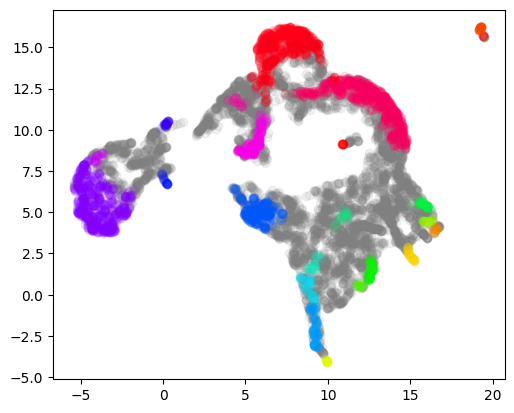

In [19]:
plot_clusters(embeddings["reduced"], clusters.labels_, n_components=2, metric="cosine")

<Axes: >

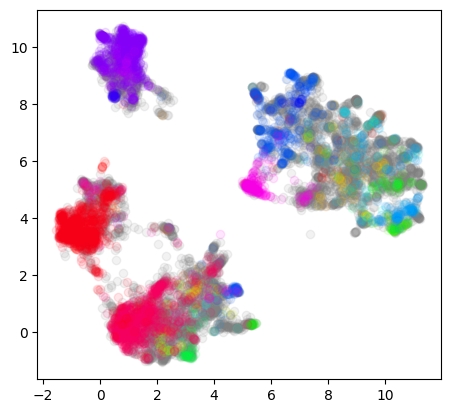

In [20]:
plot_clusters(embeddings["full"], clusters.labels_, n_components=2, metric="cosine")

#### Cluster with L2-Normalized Euclidean Distance

In [21]:
import torch.nn.functional as F

def l2_normalize(batch):
    return {"reduced_normalized": F.normalize(batch["reduced"], p=2, dim=1),
            "full_normalized": F.normalize(batch["full"], p=2, dim=1)}

embeddings = embeddings.map(l2_normalize, batched=True, batch_size=1000)

In [22]:
from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=20, min_samples=5, metric='euclidean', cluster_selection_method='eom')

In [23]:
clusters = clusterer.fit(embeddings["reduced_normalized"].numpy())

In [24]:
import numpy as np

labels, counts = np.unique(clusters.labels_, return_counts=True)
print("Labels:", labels)
print("Counts:", counts)

Labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
Counts: [4084   25   43   47   21   24   81   29  116   21  359 3664   38 1448]


<Axes: >

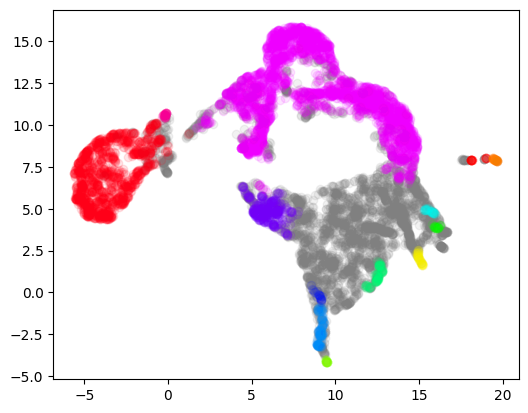

In [25]:
plot_clusters(embeddings["reduced_normalized"], clusters.labels_, n_components=2, metric="euclidean")

<Axes: >

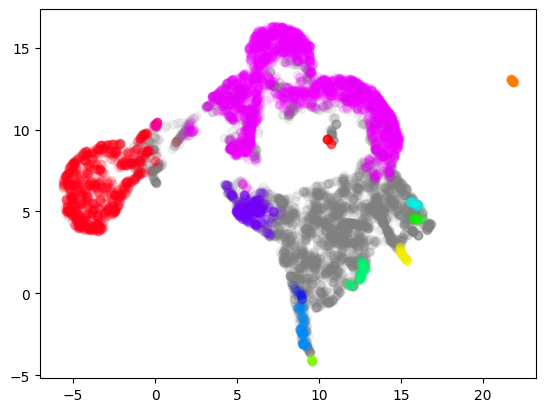

In [26]:
plot_clusters(embeddings["reduced_normalized"], clusters.labels_, n_components=2, metric="cosine")

<Axes: >

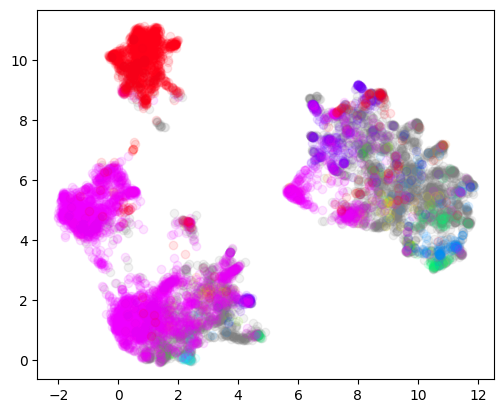

In [27]:
plot_clusters(embeddings["full_normalized"], clusters.labels_, n_components=2, metric="euclidean")